輸入立委臉書粉專內容及選舉政見資料

In [1]:
import pandas as pd
import jieba
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

pd.set_option('display.max_colwidth', None)#setting the maximize string show

fb = pd.read_csv('nysu_10902_2019立委_research.csv')
politics = pd.read_csv('9th_legislator_promise.csv')
fb.page_name.unique() #觀察人名在資料集中叫什麼名字
politics.姓名.unique()

array(['吳思瑤', '姚文智', '何志偉', '蔣萬安', '李彥秀', '林昶佐', '蔣乃辛', '費鴻泰', '賴士葆',
       '呂 孫 綾', '林 淑 芬', '高志鵬', '余天', '吳 秉 叡', '蘇 巧 慧', '張 宏 陸', '羅 致 政',
       '江 永 昌', '林 德 福', '吳 琪 銘', '羅 明 才', '黃 國 昌', '蔡適應', '鄭 運 鵬',
       '陳賴素美', '陳學聖', '鄭寶清', '呂玉玲', '趙正宇', '林為洲', '柯建銘', '陳超明', '徐志榮',
       '蔡其昌', '顏寬恒', '洪慈庸', '張廖萬堅', '盧秀燕', '沈智慧', '黃國書', '何欣純', '江啟臣',
       '王惠美', '柯呈枋', '黃秀芳', '洪宗熠', '陳素月', '馬 文 君', '許 淑 華', '蘇 治 芬',
       '劉 建 國', '李 俊 俋', '蔡 易 餘', '陳 明 文', '葉宜津', '黃偉哲', '郭國文  ', '陳亭妃',
       '林俊憲', '王定宇', '邱 議 瑩', '邱 志 偉', '劉 世 芳', '林 岱 樺', '管 碧 玲', '李 昆 澤',
       '趙 天 麟', '馬 凱 妮', '賴 瑞 隆', '蘇震清', '鍾佳濱', '莊瑞雄', '陳歐珀', '蕭美琴',
       '劉櫂豪', '楊 曜', '楊鎮浯', '陳玉珍', '陳雪生', '廖國棟', '鄭天財', '陳瑩', '高金素梅',
       '簡東明', '孔文吉', nan], dtype=object)

以新北市立委林淑芬為例，建立發文文字斷詞表

In [2]:
lin = fb[fb.page_name == "林淑芬"]
lin.head(1)

,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,created_time_taipei,...,link_name,link_description,like_count,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count
20051,169014523134260_2030287527006941,169014523134260,林淑芬,政治人物,NaN,NaN,link,https://www.facebook.com/169014523134260/posts/2030287527006941/,2019-01-15T11:26:05+0000,2019-01-15T19:26:05,...,滕西華／缺乏受害救濟、回饋制度，再生醫療條例造福的是誰？ - 報導者 The Reporter,再生醫療將成台灣產業新亮點？醫藥技術可行，不代表著社會倫理同樣可行。這是目前對《再生醫療條例》草案最大的質疑。,139,0,0,0,0,0,5,1


In [3]:
lin['new_date'] = pd.to_datetime(lin['created_time_taipei']).dt.date
lin['month_year'] = pd.to_datetime(lin['new_date']).dt.to_period('M')
lin.head(1)

<ipython-input-3-720d83586c98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin['new_date'] = pd.to_datetime(lin['created_time_taipei']).dt.date
<ipython-input-3-720d83586c98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin['month_year'] = pd.to_datetime(lin['new_date']).dt.to_period('M')


,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,created_time_taipei,...,like_count,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count,new_date,month_year
20051,169014523134260_2030287527006941,169014523134260,林淑芬,政治人物,NaN,NaN,link,https://www.facebook.com/169014523134260/posts/2030287527006941/,2019-01-15T11:26:05+0000,2019-01-15T19:26:05,...,139,0,0,0,0,0,5,1,2019-01-15,2019-01


In [4]:
# 依照按讚數 低到高排序
lin = lin.sort_values(by=['like_count'])
# 用新的排序當作順序
lin.reset_index(inplace=True)

結巴斷詞 jieba

1.   len(liu): 看劉櫂豪的貼文總共有幾筆
2.   list(liu['message']): 把要斷詞的內容轉成 list 格式
3.   創造一個新的dataframe叫做liu_docs，型態是pandas.core.frame.DataFrame
4.   原本liu_docs裡面的'jieba_results'欄位型態是pandas.core.series.Series，需要轉成'str'(字串)型態才能做後續處理。

In [5]:
doc_names = range(len(lin)) #有幾篇文章 : 444 篇文章
doc_names

range(0, 254)

In [6]:
lin = lin.replace(np.nan, '', regex=True) # 將nan取代成空白字串
text_list = list(lin['message']) # 把所有message轉成一個list 用for iterate

What is the difference between lcult() & cut()

In [7]:
# 先看第一個
words = jieba.lcut(text_list[0], cut_all = False) # lcut return a "list"
print(words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 0.700 seconds.
Prefix dict has been built succesfully.


['與淑芬', '①', '起', '勇敢', '堅持', ' ', '守護', '台灣', '！']


In [8]:
words = jieba.cut(text_list[0], cut_all = False) 
print(words)
#for word in words:
 #   print(word)

<generator object Tokenizer.cut at 0x000001A46FAE5350>


把要存斷詞結果的dataframe準備好之後，就可以開始斷詞了。</br>

第一個迴圈</br> 剛才我們知道，劉櫂豪的篇數有999篇： 我們可以用一個for迴圈來跑每一篇文章，i是對應文章的意思，會從1(第一篇)跑到999(第999篇)；</br> 而text_list就是我們剛剛轉成list型態的劉櫂豪貼文內容；text_list[1]，就是取出list第一個元素(第一篇貼文)的意思。</br>

第二個迴圈</br> words存的是文章斷詞後的集合物件(object)，我們需要跑第二個for迴圈把集合裡面的字取出來，</br> word代表斷詞集合中的一個字，先把字轉換成str(字串)型態之後，字和字之間加上空格存在一起。

append加回斷詞欄位</br> 之後把text內容存到'jieba_results'這個欄位裡面，再和liu_docs合併。</br> 最後我們liu_docs，只會一個欄位jieba_results，存斷詞之後的結果。

In [9]:
import jieba
from tqdm import tqdm
import re
jieba.load_userdict("dict.txt")
punctuation = " //，：:""()\n!！？｡＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘'‛“”„‟…‧﹏"""
re_punctuation = "[{}] ".format(punctuation)

# creat a df to store the jieba result
lin_docs = pd.DataFrame(columns=['jieba_results']) # 建立df
lin_docs['jieba_results'] = lin_docs['jieba_results'].astype('str')

for i in doc_names: #從第一篇到最後一篇
    words = jieba.cut(text_list[i], cut_all = False)
    text = ''
    for word in words:
        text = text + ' ' + str(word) 
    #print(words)
    #print(i) #第幾篇文章
    #print(text) #第幾篇文章的斷詞結果
    text = re.sub(re_punctuation, "", text) # 把上面那些符號從text中刪掉
    text = re.sub(r'[0-9]','',text) # 刪掉數字
    text = re.sub(r'[a-zA-Z]','',text) #刪掉英文字
#刪除文字 更多標點符號
    text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗🎉⏰💪]','',text)  # 注意裡面不能有空白！
    s = pd.Series({'jieba_results': text})
    lin_docs = lin_docs.append(s, ignore_index=True)#每次的斷詞結果都加回liu_docs


In [10]:
#liu_docs.iloc[400:,]  #從讚數最多的檢查

In [11]:
lin['jieba_results'] = lin_docs
lin_post = lin[['new_date','message','jieba_results','like_count']]
lin_post

,new_date,message,jieba_results,like_count
0,2019-12-18,與淑芬①起勇敢堅持 守護台灣！,與淑芬 ① 起 勇敢 堅持 守護 台灣,81
1,2019-01-11,【📣小小公民國會體驗營，最後名額釋出！】\n\n第二屆小小公民國會體驗營來囉！\n\n立法院在哪裡？\n為什麼我們需要立法院？\n立法委員的工作內容都在做什麼？\n立法委員在哪裡開會？\n電視新聞常常出現立法委員和行政部門官員的質詢和備詢，又是怎麼一回事呢？\n\n2017年我們舉辦第一屆小小公民認識國會，\n讓小小公民執行立委職權質詢環保署署長。\n今年，我們同樣規劃不同的部會官員前來備詢報告業務，\n小小公民練習上台質詢，你準備好了嗎？\n\n報名日期：即日起至1月15日（＃最後10位名額，額滿為止）\n報名方式：網路報名（https://goo.gl/3aJ6xR）、現場報名（服務處：新北市蘆洲區長興路25號）\n活動梯次：第一梯：1/22(二)9:30-12:00\n活動人數：每梯最多42人（小孩至多30位），額滿為止\n活動對象：國小四到六年級學生（最多可由一家長陪同參與）\n集合地點：林淑芬委員蘆洲服務處（新北市蘆洲區長興路25號）\n集合時間：1月22日9:15\n活動費用：150元（保險、車資、餐盒）【請至蘆洲服務處繳費，繳費完成才視同完成報名程序。若當天缺席恕不退費。】\n主辦單位：立委林淑芬辦公室\n\n＃名額有限，以蘆洲、五股、三重地區的小小公民優先錄取哦～,📣 小小 公民 國會 體驗營 最後名 額釋 出 第二 屆 小小 公民 國會 體驗 營來 囉 立法院 在 哪裡 為 什麼 我們 需要 立法院 立法委員 的 工作 內容 都 在 做 什麼 立法委員 在 哪裡 開會 電視 新聞 常常 出現 立法委員 和 行政部 門官員 的 質詢 和 備詢 又 是 怎麼 一 回事 呢 年 我們 舉辦 第一 屆 小小 公民 認識 國會 讓 小小 公民 執行 立委 職權 質詢 環保署 署長 今年 我們 同樣 規劃 不同 的 部會 官員前 來備 詢報 告業務 小小 公民 練習 上台 質詢 你 準備 好 了 嗎 報名 日期 即日起 至 月 日 最 後 位名額 額滿 為止 報名 方式 網路 報名 現場 報名 服務處 新北市 蘆洲 區長 興路 號 活動 梯次 第一 梯 二 活動 人數 每梯 最多 人 小孩 至多 位 額滿 為止 活動 對象 國小 四到 六年 級學生 最多 可 由 一家 長 陪同 參與 集合 地點 林淑芬 委員 蘆洲 服務處 新北市 蘆洲 區長 興路 號 集合 時間 月 日 活動 費用 元 保險 車資 餐盒 請 至 蘆洲 服務處 繳費 繳費 完成 才 視同 完成 報名 程序 若 當天 缺席 恕 不 退費 主辦 單位 立委 林淑芬 辦 公室 名額 有限 以 蘆洲 五股 三重 地區 的 小小 公民 優先 錄取 哦 ～,134
2,2019-01-15,,,139
3,2019-01-23,【小小公民國會體驗營第二梯次，徐國勇部長率隊備詢！】\n\n今天國會體驗營模擬委員會會議，\n特別感謝內政部徐國勇部長撥冗與會。\n\n口才流利的「部長阿伯」，\n用淺顯易懂的方式介紹內政部的業務，\n而且答詢完全比照正式委員會，\n除了說明政策立場，也做了政策裁示。\n\n小小公民把握難得機會，與部長討論政策，\n活動聚焦在社區治安、災害防救與國家公園保育與開發，\n但小立委們更關切警察勤務，\n提問範圍包含「警察配戴的警械會因為職位不同嗎？」\n「警察不小心射殺到路人怎麼辦？」、\n「歹徒如果是警察的親友，他不敢開槍怎麼辦？」等等，\n\n也有小立委以自身經驗出發，\n關切「校園霸凌事件，警察是否能夠介入？」\n以及騎樓違停佔用，造成上下學走路經常需繞道而行，\n期盼政府能協助解決。\n\n兩天的體驗營圓滿落幕，\n如果想掌握第一手淑芬的活動資訊，\n記得要密切關注淑芬Line的訊息動態喔～,小小 公民 國會 體驗營 第二 梯次 徐國勇 部長 率隊 備詢 今天 國會 體驗營 模擬 委員 會會議 特別 感謝 內政部 徐國勇 部長 撥 冗 與 會 口才 流利 的 部長 阿伯 用 淺顯 易懂 的 方式 介紹 內政部 的 業務 而且 答詢 完全 比照 正式 委員 會 除了 說明 政策 立場 也 做 了 政策 裁示 小小 公民 把握 難得 機會 與 部長 討論 政策 活動 聚焦 在 社區 治安 災害 防救 與 國家 公園 保育 與 開發 但 小 立委 們 更 關切 警察 勤務 提問 範圍 包含 警察 配戴 的 警械 會 因為 職位 不同 嗎 警察 不 小心 射殺 到 路 人 怎麼 辦 歹徒 如果 是 警察 的 親友 他 不敢 開槍 怎麼 辦 等等 也 有 小 立委 以 自身 經驗 出發 關切 校園霸凌 事件 警察 是否 能夠 介入 以及 騎樓 違停 佔 用 造成 上下 學 走路 經常 需繞 道 而行 期盼 政府 能協助 解決 兩天 的 體驗 營圓滿 落幕 如果 想 掌握 第一手 淑芬 的 活動 資訊 記得 要 密切 關注 淑芬 的 訊息動態 喔 ～,154
4,2019-10-24,,,155
...,...,...,...,...
249,2019-11-17,#就憑這篇胡說八道的報導指控我們\nhttps://news.ltn.com.tw/news/politics/breakingnews/2442645\n\n誰加蔥?誰加料?\n哪裡加蔥?哪裡加料?\n修法過程哪裡不理性?\n委員會實質審查過程，全程參與的沒幾個，\n不知道誰不理性?哪裡不理性了?\n沒共識的責任在我們嘛？\n妳最好站出來辯論一下 說清楚。\n不用老是指著人民的鼻子教訓人民。,就 憑 這篇 胡說 八道 的 報導 指控 我們 誰 加蔥 誰 加料 哪裡 加蔥 哪裡 加料 修法 過程 哪裡 不 理性 委員 會 實質 審查 過程 全程 參與 的 沒 幾個 不 知道 誰 不 理性 哪裡 不 理性 了 沒 共識 的 責任 在 我們 嘛 妳 最好 站 出來 辯論 一下 說 清楚 不用 老是 指著 人民 的 鼻子 教訓 人民,6568
250,2019-04-23,感謝各位好朋友的支持，\n淑芬確定參與2020年立委選舉。\n明年大選在財團當道，以及中國的威脅下，\n將是一場硬仗，\n淑芬懇請大家一起團結，\n與淑芬共同努力，\n我們還要打贏2020選戰。,感謝 各位 好 朋友 的 支持 淑芬 確定 參與 年 立委 選舉 明年 大選 在 財團 當道 以及 中國 的 威脅 下 將是 一場 硬仗 淑 芬懇 請 大家 一起 團結 與淑芬 共同努力 我們 還要 打贏 選戰,7109
251,2019-11-18,【不要再以無共識之名，丟下礦業法！】\n\n從2017年7月礦業法在臨時會開啟首次審查後，\n到2018年5月30日共七次委員會11天審查並審查完竣出委員會，\n到2019年5月29日歷經四次黨團協商，\n已由原本多達13個版本，\n整理到僅剩26個條文保留送交院會處理，\n大部分為內容置於何條次之爭議。\n\n此外，＃多數條文更已達成下列共識：\n1、採礦需合理利用，並兼顧經濟、環境與文化永續發展！（第1條）\n2、主管機關應針對礦種每五年提出整體產業政策評估報告（第5-1條）\n3、原住民基於傳統文化、祭儀、非營利而採取礦物除罪化（第7條）\n4、除了石油礦及天然氣礦之外的水平面積最多300公頃（第8條）\n5、特定條件情節重大違規者不予設定礦權（第19條）\n6、環境敏感區內採礦需該管機關同意（第29條）\n7、霸王條款：礦權展限不再「原則許可，例外否准」，礦業權者拿不到礦權，政府不用再賠天價補償金！（第33條）\n8、霸王條款：礦業權者需先取得礦業用地該土地與建物所有權人同意才可使用土地！（第47條）\n\n而 ＃尚未達成共識的是：\n1、礦區周邊居民需同意（29條第4款）\n2、礦權展限需經土地主管機關內政部同意（33條第7款）\n3、礦業權者需提出關礦計畫（45條）\n\n關礦計畫中，\n在我們的版本中，關礦計畫要求礦業權者，\n除了礦區土地復育及再利用規劃等環境問題，\n更要求礦業權者需提出礦後社區之社會經濟發展方案、\n礦場作業人員安置與輔導轉業措施。\n＃礦場員工的工作權，\n＃就是大家最在乎的就業保障問題。\n\n原住民的諮商同意權部分，\n我們認為應尊重原住民族委員意見，\n或回歸原基法處理。\n\n至於業者與行政部門關心的環評這條條文（58-1）雖然已在委員會通過，\n對我們而言，\n為了法案通過，\n＃我們認為仍有協商的空間。\n\n礦是國家的，\n採礦是特許權，\n為了修正這嚴重傾向圖利礦業權者的礦業法，\n為了台灣的環境永續與兼顧產業發展，我們已退無可退。\n\n＃加什麼蔥？ \n＃我們一再退讓已經退無可退\n＃2020贏得勝利 ＃不要丟下礦業法,不要 再 以 無 共識 之名 丟下 礦業法 從 年 月 礦業法 在 臨時會 開啟 首次 審查 後 到 年 月 日共 七次 委員 會 天 審查 並 審查 完竣 出 委員 會 到 年 月 日 歷經 四次 黨團 協商 已 由 原本 多達 個 版本 整理 到僅 剩 個 條文 保留 送交 院會 處理 大部分 為 內容置 於 何條 次之 爭議 此外 多數 條文 更 已 達成 下列 共識 採礦 需 合理 利用 並兼顧 經濟 環境 與 文化 永續發展 第 條 主管 機關 應 針對 礦種 每 五年 提出 整體 產業 政策 評估 報告 第 條 

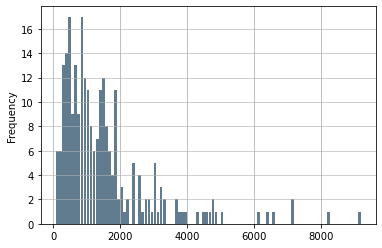

In [12]:
# 看讚數的分佈 y 軸是該讚數的貼文數 來看我們要怎麼取哪個讚數區間資料
commutes = lin_post['like_count']
commutes.plot.hist(grid=True, bins=100, rwidth=0.9,
color='#607c8e')
plt.grid(axis='y', alpha=0.75)

In [13]:
temp = lin_post[(lin_post['like_count'] <= 1500) & (lin_post['like_count'] > 500)] #讚數大於500 小於1000才取 : 201  篇文章
temp

,new_date,message,jieba_results,like_count
48,2019-02-26,今天總質詢，\n質詢蘇院長要求解決「五股輕軌」F6、F7車站設置在堤防上安全的問題，\n盡速通過「可行性評估」。\n\n究竟為什麼新北市政府送給中央的「五泰輕軌可行性評估」一直無法通過呢？\n\n究其最主要的原因，\n在於新北市政府的可行性評估，\n把F6 跟F7兩站的車站站體，\n#設置在只有6米高的堤防上。\n\n經濟部「水利署」多次函覆審查意見：\n第一，\n「水利法」本就不允許河川區域內建造房屋或其他妨礙河川、河川水路行為，以免影響水路及安全。\n\n第二，目前的堤防為防洪保護20年重現期距，\n在目前堤防上蓋站體，\n會有高度淹水風險。\n\n第三，\n若將堤防增高，則站體將逼近台64線樑底，\n旅客與進出站路線變陡，影響安全。\n\n第四，堤頂道路本來就是防汛、搶險的重要道路，\n於堤頂設站將影響救災、搶險時效。\n\n從103年至107年，\n新北市府總共提了五次的「五泰輕軌可行性評估」，\n關於「運量預測」、「經費籌措」等，\n新北市府有持續依交通部的審查意見進行修正，\n唯獨在F6、F7的站體設置，\n從第一次報告到第五次報告中，\n都規劃將這兩站體設置在堤防上，沒有修正，\n都未針對這兩站體設置違反「水利法」，且影響救災、安全的區位的問題進行修正。\n\n蘇院長、經濟部沈榮津部長及交通部長林佳龍今天承諾，\n針對新北市府所提之五泰輕軌路線，\n將提供專業的建議，\n希望新北市府能夠儘速修正F6、F7的站體設置規劃，\n重新評估路線，\n中央也會在安全、合法、不影響救災之下，\n儘速通過五泰輕軌可行性評估報告。,今天 總 質詢 質詢 蘇院長 要求 解決 五股 輕軌 車站 設置 在 堤防 上 安全 的 問題 盡速 通過 可行性 評估 究竟 為 什麼 新北 市政府 送給 中央 的 五泰 輕軌 可行性 評估 一直 無法 通過 呢 究其 最 主要 的 原因 在 於 新北 市政府 的 可行性 評估 把 跟 兩站 的 車站 站體 設置 在 只有 米 高 的 堤防 上 經濟部 水利 署 多次 函覆 審查 意見 第一 水利 法 本 就 不 允許 河川 區域 內 建造 房屋 或 其他 妨礙 河川 河川 水路 行為 以免 影響 水路 及 安全 第二 目前 的 堤防 為 防洪 保護 年重 現期 距 在 目前 堤防 上蓋 站體 會 有 高度 淹水 風險 第三 若將 堤防 增高 則站 體將 逼近 台 線 樑 底 旅客 與 進出 站 路線 變 陡 影響 安全 第四 堤頂 道路 本來 就是 防汛 搶險 的 重要 道路 於 堤 頂 設站 將影響 救災 搶險 時效 從 年 至 年 新北 市府 總共提 了 五次 的 五泰 輕軌 可行性 評估 關於 運量 預測 經費 籌措 等 新北 市府 有 持續 依 交通部 的 審查 意見 進行 修正 唯獨 在 的 站體 設置 從 第一次 報告 到 第五次 報告 中 都 規劃將 這兩站 體設 置 在 堤防 上 沒有 修正 都 未 針對 這兩站 體設 置 違反 水利 法 且 影響 救災 安全 的 區位 的 問題 進行 修正 蘇院長 經濟部 沈榮津部長 及 交通部長 林佳龍 今天 承諾 針對 新北 市府 所 提之五泰 輕軌 路線 將 提供 專業 的 建議 希望 新北 市府 能 夠 儘 速 修正 的 站體 設置 規劃 重新 評估 路線 中央 也 會 在 安全 合法 不影響 救災 之下 儘 速 通 過 五 泰 輕軌 可行性 評估 報告,507
49,2020-01-03,台灣要贏 結伴同行,台灣 要贏 結伴 同行,509
50,2019-11-14,夜深腦子\n突然浮現幾個字\n「克勞塞維玆」魔咒。,夜深 腦子 突然 浮現 幾個 字 克勞塞維 玆 魔咒,511
51,2019-12-29,【小獅王歷險記兒童劇圓滿成功！】\n淑芬長期舉辦的親子電影院，\n陪伴選區的親子度過盛夏週末的夜晚。\n今年首度嘗試舉辦兒童劇，\n陽光耀眼絢麗的週六午後，親子齊聚戶外兒童劇，\n感謝老天爺的好天氣，兒童劇團圓滿落幕！\n孩子們投入劇情，熱絡地大聲應答協助小獅王闖關，\n有獎徵答時，雙手張牙舞爪學小獅王的模樣，真是俏皮可愛。\n為了讓孩子們開心，\n這次活動動員志工們幫忙爆米花、充氣氣球，\n感謝所有願意參與的家長，以及志工好朋友們，\n我們一起度過美好的週末。\n未來若有機會，\n淑芬會繼續辦，而且要辦得更好！,小獅王歷險記 兒童 劇圓滿 成功 淑芬 長期 舉辦 的 親子電 影院 陪伴 選區 的 親子度過 盛夏 週末 的 夜晚 今年 首度 嘗試 舉辦 兒童劇 陽光 耀眼 絢麗 的 週六午 後 親子 齊聚 戶外兒 童劇 感謝 老天 爺的 好 天氣 兒童 劇團 圓滿 落幕 孩子 們 投入 劇情 熱絡 地大聲 應答 協助 小獅王 闖關 有獎 徵答 時 雙手 張牙舞 爪學 小獅王 的 模樣 真是 俏皮 可愛 為 了 讓 孩子 們 開心 這次 活動 動員 志工們 幫忙 爆米花 充氣 氣球 感謝 所有 願意 參與 的 家長 以及 志工 好 朋友 們 我們 一起 度過 美好 的 週末 未來 若 有 機會 淑 芬會 繼續 辦 而且 要 辦得 更好,516
52,2019-09-18,摘錄，\n「楊逵於1949年於上海大公報發表【和平宣言】，數百字的文字，被判處12年徒刑。\n這樣的情況，在現在正發生於新疆的哈薩克族與香港特區政府下的香港人身上。\n以警察、特務、軍隊為主的國家暴力，選擇性的執法、壓迫，強逼在一中大一統框架下的弱小民族，放棄自己的身分，捨棄特殊性，包含哈薩克語的音樂、包含粵語教學。\n歷史不是過去，而是現在，更是未來。」,摘錄 楊逵 於 年 於 上海 大公 報發表 和平 宣言 數 百字 的 文字 被判 處 年 徒刑 這樣 的 情況 在 現在 正發生 於 新疆 的 哈薩克族 與 香港 特區 政府 下 的 香港 人 身上 以 警察 特務 軍隊 為 主 的 國家 暴力 選擇性 的 執法 壓迫 強逼 在 一中 大一統 框架 下 的 弱小民族 放棄 自己 的 身分 捨 棄 特殊性 包含 哈薩克語 的 音樂 包含 粵語 教學 歷史 不是 過去 而是 現在 更是 未來 」,520
...,...,...,...,...
160,2019-02-09,國家最嚴重的問題之一,國家 最 嚴重 的 問題 之一,1458
161,2020-01-01,【2020 新年快樂！】\n\n親愛的好朋友們，\n感謝過去一年有大家的支持與陪伴。\n未來一年，\n讓我們再一同結伴同行。\n\n一起面對所有挑戰，\n一起迎向希望未來！\n\n淑芬祝福所有好朋友們，\n新的一年平安、順心、新年快樂,新年 快樂 親愛的 好 朋友 們 感謝過 去 一年 有 大家 的 支持 與 陪伴 未來 一年 讓 我們 再 一同 結伴 同行 一起 面對 所有 挑戰 一起 迎 向 希望 未來 淑芬 祝福 所有 好 朋友 們 新 的 一年 平安 順心 新年 快樂,1461
162,2019-03-04,一個助理久咳未癒，\n我跟他兩個人在討論關於咳嗽的故事，\n他的故事令人感觸良多，\n他說，\n「真的窮人， 真的是吃香灰的 。 \n我還有當過小桌頭 ，\n後來我發現我媽說的是真理，\n說窮的人，\n有時只剩下依靠信仰當成力量。」\n\n突然我想起韓片那一個粗魯地、罵髒話的「地獄奶奶」說過，\n窮人已經一無所有了，\n唯一僅有的就只能大聲咒罵，\n你們還一直叫我們閉嘴，\n#我們就偏偏不要。\n\n#初衷,一個 助理 久咳未癒 我 跟 他 兩個 人 在 討論關 於 咳嗽 的 故事 他 的 故事 令人 感觸 良多 他 說 真的 窮人 真的 是 吃 香灰 的 我 還有 當過 小桌 頭 後 來 我 發現 我媽 說 的 是 真理 說 窮 的 人 有時 只 剩下 依靠 信仰 當成 力量 突然 我 想起 韓片 那 一個 粗魯地 罵 髒 話 的 地獄 奶奶 說過 窮人 已經 一無 所有 了 唯一 僅有 的 就 只能 大聲 咒 罵 你們還 一直 叫 我們 閉嘴 我們 就 偏偏 不要 初衷,1491
163,2019-11-27,【淑芬的線上捐款平台出爐！】\n\n上週公佈淑芬的捐款帳號跟政治獻金專戶後，\n很多人在詢問，\n是否有匯款或轉帳之外的捐款方式來支持淑芬。\n淑芬很感謝大家的支持，\n線上捐款平台今天設置好囉！\n\n大家可以透過信用卡、線上ATM、ATM轉帳、\n超商代碼等方式來小額支持淑芬。\n\n我一直認為，\n不是因為看見改變而堅持，\n而是因為堅持才會有改變。\n\n2020的選戰，需要每一個你一起幫忙，\n繼續讓淑芬留在立法院，\n推動修法、爭取建設預算，\n讓人民的生活過得更好！\n\n＃敢堅持說真話\n＃小額捐款支持林淑芬\n\nhttps://donate.newebpay.com/linshufen/2020,淑芬 的 線上 捐款 平台 出爐 上週 公佈 淑芬 的 捐款 帳號 跟 政治獻金 專戶 後 很多 人 在 詢問 是否 有 匯款 或 轉帳 之外 的 捐款 方式 來 支持 淑芬 淑芬 很 感謝 大家 的 支持 線上 捐款 平台 今天 設置 好 囉 大家 可以 透過 信用卡 線上 轉帳 超 商代 碼 等 方式 來小額 支持 淑芬 我 一直 認為 不是 因為 看見 改變 而 堅持 而是 因為 堅持 才 會 有 改變 的 選戰 需要 每一個 你 一起 幫忙 繼續 讓淑芬 留在 立法院 推動 修法

TF-IDF
我們把剛才斷好詞的貼文，轉成list形式，全部放到corpus變數裡面，方便做tf-idf處理。

CountVectorizer算字頻（搭配fit_transform）
TfidfTransformer計算TFIDF

In [14]:
corpus = temp['jieba_results'].values.tolist() #如果不做這個、結果會不同 太generall

In [15]:
# TF-IDF
# coding:utf-8  

#算字頻
from sklearn.feature_extraction.text import CountVectorizer  
vectorizer = CountVectorizer()  # 計算單字出現在文件中的次數
X = vectorizer.fit_transform(corpus) #  input must be a list, return a matrix (#of corpus) x (# of word) # 201 x 4835
word = vectorizer.get_feature_names() # column name which is the word
message_column = word

#計算TFIDF
from sklearn.feature_extraction.text import TfidfTransformer  # 計算tfidf
transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X) # X : corpus x word matrix, output:201 x 4835

In [16]:
tfidf_view = pd.DataFrame(tfidf.toarray(), columns = vectorizer.get_feature_names())
tfidf_view

,一一,一中,一些,一份,一個,一再,一切,一則,一千多名,一半,...,黑衣人,黑麥,黨主席,黨內,黨團,黨部,鼓勵,鼠年,鼻子,齊聚
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11017
4,0.0,0.144749,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
113,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
114,0.0,0.000000,0.0,0.0,0.173556,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
115,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [17]:
# #使用LDA演算法
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=6, random_state=None)
LDA.fit(X) # 用countrvectorizer() result 去fit 

topic_message = list()
#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    mes_topic = [vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(mes_topic)
    for i in mes_topic:
        topic_message.append(i)

TOP 10 WORDS PER TOPIC #0
['優先', '家庭', '安全', '大家', '淑芬', '公司', '派遣', '自己', '職災', '勞工']
TOP 10 WORDS PER TOPIC #1
['臺灣', '監測', '社會', '如果', '可以', '一年', '民主', '要求', '我們', '國家']
TOP 10 WORDS PER TOPIC #2
['我們', '支持', '建設', '補助', '改善', '工程', '爭取', '五股', '三重', '淑芬']
TOP 10 WORDS PER TOPIC #3
['提供', '放寬', '淑芬', '人民', '五股', '食藥署', '殘留容', '我們', '許量', '塑膠']
TOP 10 WORDS PER TOPIC #4
['競選總部', '公共', '地區', '立委', '清潔', '國家', '我們', '蘆洲', '堤防', '五股']
TOP 10 WORDS PER TOPIC #5
['救濟', '利用', '補償', '反應', '大家', '不良', '政府', '接種', '台灣', '疫苗']


In [18]:

LDA.fit(tfidf) # 用tfidf result 去fit 

#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['我們', '短缺', '堤防', '公道', '嚴重', '現金', '遲來', '前進', '早餐', '國家']
TOP 10 WORDS PER TOPIC #1
['蘆洲', '勞工', '弱勢', '經濟', '預算', '民主', '職災', '工程', '爭取', '補助']
TOP 10 WORDS PER TOPIC #2
['成熟', '產黨', '國共', '地震', '民調', '什麼', '新疆', '五股', '統治', '轉紅單']
TOP 10 WORDS PER TOPIC #3
['有點', '議長', '有害', '覺得', '管理', '派遣', '不禮貌', '鄉民團', '自毀', '根基']
TOP 10 WORDS PER TOPIC #4
['幸福', '結伴', '要贏', '同行', '蘆洲', '大家', '呵呵', '疫苗', '我們', '台灣']
TOP 10 WORDS PER TOPIC #5
['競選總部', '湯圓', '支持', '三重', '社發', '中國', '一年', '淑芬', '大家', '五股']


In [19]:
#政見做斷詞

politics_lin = politics[politics.姓名 == "林 淑 芬"].政見.to_string()
politics_lin = re.sub(re_punctuation, "", politics_lin)
politics_lin = re.sub(r'[0-9]','',politics_lin)
politics_lin = re.sub(r'[a-zA-Z]','',politics_lin)
politics_lin = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗]','',politics_lin)  # 注意裡面不能有空白！
jieba.load_userdict("dict.txt")
words = jieba.lcut(politics_lin, cut_all = False)


In [20]:
#觀察政見的斷詞結果
inspect_words = jieba.cut(politics_lin, cut_all = False)
text = ''
for word in inspect_words:
    text = text + ' ' + str(word) 
text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗]','',text)
text = re.sub(re_punctuation, "", text)


In [21]:
# 政見做tfidf
p_vectorizer = CountVectorizer()  
p_X = p_vectorizer.fit_transform(words)  
word = p_vectorizer.get_feature_names() 
p_transformer = TfidfTransformer()  
p_tfidf = p_transformer.fit_transform(p_X) #143 word in 

p_LDA = LatentDirichletAllocation(n_components=8, random_state=None)

#政見做LDA
p_LDA.fit(p_tfidf)
topic_politics = list()
#觀看結果
for i,topic in enumerate(p_LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    topic_p = [p_vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(topic_p)
    for i in topic_p:
        topic_politics.append(i)


TOP 10 WORDS PER TOPIC #0
['日本', '黑心油弊案', '空污法', '關廠', '投票', '這一邊', '救濟法', '受害', '推動', '立法']
TOP 10 WORDS PER TOPIC #1
['高牆', '長照制度', '持續', '受害者', '山河', '廢棄物減量及循環利用法', '林淑芬', '安全', '改革', '食品']
TOP 10 WORDS PER TOPIC #2
['責無旁貸', '監督', '修法', '毒性化學物質管理法', '頂新', '勞動', '以建構', '勞工', '未來', '完成']
TOP 10 WORDS PER TOPIC #3
['繼續', '土污法', '盡到', '長照服務', '預防', '土地', '多元', '守護', '職災', '政府']
TOP 10 WORDS PER TOPIC #4
['這些', '捍衛', '辦法', '照顧', '暗夜', '照保險法', '權益淑芬', '空氣', '還給', '尊嚴']
TOP 10 WORDS PER TOPIC #5
['保障', '沒修', '居家', '濕地法', '保障法', '管理制度', '勞基法', '歇業', '負擔', '台灣']
TOP 10 WORDS PER TOPIC #6
['勇敢', '未來將', '有國', '壓力', '服務', '國土三法', '失去', '海沒', '提供', '建教生']
TOP 10 WORDS PER TOPIC #7
['長照服務法', '日間', '各種', '工人', '保護', '選舉', '保險法', '老化', '人民', '淑芬']


In [22]:
# #政見所有topic 總表
for i in topic_politics:
#for i in topic_:# 文章內容的topic所有字的總表
    print(i,end = ', ')

日本, 黑心油弊案, 空污法, 關廠, 投票, 這一邊, 救濟法, 受害, 推動, 立法, 高牆, 長照制度, 持續, 受害者, 山河, 廢棄物減量及循環利用法, 林淑芬, 安全, 改革, 食品, 責無旁貸, 監督, 修法, 毒性化學物質管理法, 頂新, 勞動, 以建構, 勞工, 未來, 完成, 繼續, 土污法, 盡到, 長照服務, 預防, 土地, 多元, 守護, 職災, 政府, 這些, 捍衛, 辦法, 照顧, 暗夜, 照保險法, 權益淑芬, 空氣, 還給, 尊嚴, 保障, 沒修, 居家, 濕地法, 保障法, 管理制度, 勞基法, 歇業, 負擔, 台灣, 勇敢, 未來將, 有國, 壓力, 服務, 國土三法, 失去, 海沒, 提供, 建教生, 長照服務法, 日間, 各種, 工人, 保護, 選舉, 保險法, 老化, 人民, 淑芬, 

In [23]:
#在LDA結果中每個Topic政見的詞 、 臉書貼文的詞的交集 
#set(topic_politics).intersection(topic_message) 
Counter(topic_politics+topic_message) #綜合臉書發文、政見 Topic 的詞 看出現次數
#產業升級、園區、高科技園區、加工區 、楠梓、交通、三鐵同構

Counter({'日本': 1,
         '黑心油弊案': 1,
         '空污法': 1,
         '關廠': 1,
         '投票': 1,
         '這一邊': 1,
         '救濟法': 1,
         '受害': 1,
         '推動': 1,
         '立法': 1,
         '高牆': 1,
         '長照制度': 1,
         '持續': 1,
         '受害者': 1,
         '山河': 1,
         '廢棄物減量及循環利用法': 1,
         '林淑芬': 1,
         '安全': 2,
         '改革': 1,
         '食品': 1,
         '責無旁貸': 1,
         '監督': 1,
         '修法': 1,
         '毒性化學物質管理法': 1,
         '頂新': 1,
         '勞動': 1,
         '以建構': 1,
         '勞工': 2,
         '未來': 1,
         '完成': 1,
         '繼續': 1,
         '土污法': 1,
         '盡到': 1,
         '長照服務': 1,
         '預防': 1,
         '土地': 1,
         '多元': 1,
         '守護': 1,
         '職災': 2,
         '政府': 2,
         '這些': 1,
         '捍衛': 1,
         '辦法': 1,
         '照顧': 1,
         '暗夜': 1,
         '照保險法': 1,
         '權益淑芬': 1,
         '空氣': 1,
         '還給': 1,
         '尊嚴': 1,
         '保障': 1,
         '沒修': 1,
         '居家': 1,
         '

我們可以用 臉書貼文和政見 Topic word 的交集 會推測
劉世芳的幾個重點
1. 經濟相關的科技 園區和加工區
    - 高科技、發展、產業、加工區、園區、產業、就業、計畫、建設、
2. 楠梓地區
    -楠梓
3. 交通
    -三鐵同構、中油、交通、
4. 環境
    -環境、綠能、

職災 相關tf idf 高 (以下討論臉書貼文)

In [24]:
top_10_message = tfidf_view.sort_values(by = ['職災'], ascending = False).index[:10] # 把高科技tfidf 高的文章做排序取top 10的文章 拿出文章的index
tfidf_view.sort_values(by = ['職災'], ascending = False).head(10)

,一一,一中,一些,一份,一個,一再,一切,一則,一千多名,一半,...,黑衣人,黑麥,黨主席,黨內,黨團,黨部,鼓勵,鼠年,鼻子,齊聚
47,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.049428,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
68,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
59,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
74,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
81,0.0,0.0,0.0,0.0,0.123189,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [25]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[47,]).sort_values(by = 47, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,47
職災,0.567120
勞工,0.348604
那些,0.197714
家庭,0.186166
法案,0.181925
...,...
尊嚴,0.000000
尊重,0.000000
尋求,0.000000
對民眾,0.000000


In [26]:
#這些都是讚數很高的文章 每篇文章最高的tfidf 詞
message_newtfidf = tfidf_view
message_newtfidf['term'] = message_newtfidf[message_column].idxmax(axis = 1)
message_newtfidf['term'].tail(20) # 在這邊的話看讚數最多的文章他們tfidf 最高的詞是什麼

97       原民
98       常態
99       一一
100      一一
101      命格
102      捷運
103      職災
104      旺旺
105      三重
106    人人皆知
107      這種
108      民調
109      主機
110      資本
111      三重
112      之一
113      一年
114      故事
115      捐款
116      五股
Name: term, dtype: object

In [27]:
#假如以剛剛科學園區相關主題為例 想看tfidf 最高的詞是科學園區的文章
message_newtfidf[message_newtfidf['term']=="原民"]

,一一,一中,一些,一份,一個,一再,一切,一則,一千多名,一半,...,黑麥,黨主席,黨內,黨團,黨部,鼓勵,鼠年,鼻子,齊聚,term
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,原民


In [28]:
# 會發現文章出現tfidf是產業的很少，很正常 因為出現太多反而tfidf不會高！
temp.iloc[97,]

new_date                                                                                                                  2019-10-24
message                                高山設立升旗台需徵詢原民同意，\n在原民土地上挖礦展限二十年，更需徵詢原民同意。\n\n＃所以高等法院撤銷亞泥展限\n＃目前礦業法不修亞泥也不用改正\n＃儘速通過礦業法\n＃就差臨門一腳
jieba_results     高山 設立 升旗台 需徵詢 原民 同意 在 原民 土地 上 挖礦 展限 二十年 更 需徵詢 原民 同意  所以 高等法院 撤銷 亞泥 展限 目前 礦業法 不 修亞泥 也 不用 改正 儘 速 通 過 礦 業 法 就 差 臨門 一腳
like_count                                                                                                                      1301
Name: 145, dtype: object

來看楠梓 ： 在臉書發文的topic中topic2,4,7 出現很多次楠梓 

In [29]:
message_newtfidf[message_newtfidf['term']=="中國"]

,一一,一中,一些,一份,一個,一再,一切,一則,一千多名,一半,...,黑麥,黨主席,黨內,黨團,黨部,鼓勵,鼠年,鼻子,齊聚,term
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,中國


In [30]:
temp.iloc[25,]

new_date                                                                                                                                                                                                                                                                                                                                                                                                                                                2019-01-30
message                                                                                                                                  摘錄  ： \n「中國給台灣人高薪是特殊歷史背景才可能的現象，那個背景叫中國崛起。中國崛起在世界史上只可能發生一次，不可能持續也不可能重覆，連中國也無法重覆本身的崛起經驗。\n 當然，因為中國經濟規模大於台灣，一定會有許多產業規模大於台灣。可想而知，將來還是會有台灣人在中國找到更大舞台，就好比加拿大人如果專業是金融，他的大舞台就是紐約，不是多倫多。問題是，加拿大人如果不夠秀異，紐約投資銀行為什麼要聘他？\n    當中國成長速度趨近台灣，台灣人要證明比中國人秀異的門檻就會越來越高。中國有十三億人，中國最不缺人，也不缺人才，它只缺它本身培養不出來的人才。去中國念大學，你就成了它可以自己培養的人才。你要怎麼比中國人秀異？」
jieba_results     摘錄 中國 給 台灣 人 高薪 是 特殊 歷史背景 才 可能 的 現象 那個 背景 叫 中國崛起  中國崛起 在 世界史 上 只 可能 發生 一次 不 可能 持

In [31]:
# LDA : 看每篇文章被分配在哪些主題  (tfidf)
#review topic 結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['我們', '短缺', '堤防', '公道', '嚴重', '現金', '遲來', '前進', '早餐', '國家']
TOP 10 WORDS PER TOPIC #1
['蘆洲', '勞工', '弱勢', '經濟', '預算', '民主', '職災', '工程', '爭取', '補助']
TOP 10 WORDS PER TOPIC #2
['成熟', '產黨', '國共', '地震', '民調', '什麼', '新疆', '五股', '統治', '轉紅單']
TOP 10 WORDS PER TOPIC #3
['有點', '議長', '有害', '覺得', '管理', '派遣', '不禮貌', '鄉民團', '自毀', '根基']
TOP 10 WORDS PER TOPIC #4
['幸福', '結伴', '要贏', '同行', '蘆洲', '大家', '呵呵', '疫苗', '我們', '台灣']
TOP 10 WORDS PER TOPIC #5
['競選總部', '湯圓', '支持', '三重', '社發', '中國', '一年', '淑芬', '大家', '五股']


In [32]:
#可以猜猜看第一篇文是哪個topic 
temp.iloc[:,[0,2]]

,new_date,jieba_results
48,2019-02-26,今天 總 質詢 質詢 蘇院長 要求 解決 五股 輕軌 車站 設置 在 堤防 上 安全 的 問題 盡速 通過 可行性 評估 究竟 為 什麼 新北 市政府 送給 中央 的 五泰 輕軌 可行性 評估 一直 無法 通過 呢 究其 最 主要 的 原因 在 於 新北 市政府 的 可行性 評估 把 跟 兩站 的 車站 站體 設置 在 只有 米 高 的 堤防 上 經濟部 水利 署 多次 函覆 審查 意見 第一 水利 法 本 就 不 允許 河川 區域 內 建造 房屋 或 其他 妨礙 河川 河川 水路 行為 以免 影響 水路 及 安全 第二 目前 的 堤防 為 防洪 保護 年重 現期 距 在 目前 堤防 上蓋 站體 會 有 高度 淹水 風險 第三 若將 堤防 增高 則站 體將 逼近 台 線 樑 底 旅客 與 進出 站 路線 變 陡 影響 安全 第四 堤頂 道路 本來 就是 防汛 搶險 的 重要 道路 於 堤 頂 設站 將影響 救災 搶險 時效 從 年 至 年 新北 市府 總共提 了 五次 的 五泰 輕軌 可行性 評估 關於 運量 預測 經費 籌措 等 新北 市府 有 持續 依 交通部 的 審查 意見 進行 修正 唯獨 在 的 站體 設置 從 第一次 報告 到 第五次 報告 中 都 規劃將 這兩站 體設 置 在 堤防 上 沒有 修正 都 未 針對 這兩站 體設 置 違反 水利 法 且 影響 救災 安全 的 區位 的 問題 進行 修正 蘇院長 經濟部 沈榮津部長 及 交通部長 林佳龍 今天 承諾 針對 新北 市府 所 提之五泰 輕軌 路線 將 提供 專業 的 建議 希望 新北 市府 能 夠 儘 速 修正 的 站體 設置 規劃 重新 評估 路線 中央 也 會 在 安全 合法 不影響 救災 之下 儘 速 通 過 五 泰 輕軌 可行性 評估 報告
49,2020-01-03,台灣 要贏 結伴 同行
50,2019-11-14,夜深 腦子 突然 浮現 幾個 字 克勞塞維 玆 魔咒
51,2019-12-29,小獅王歷險記 兒童 劇圓滿 成功 淑芬 長期 舉辦 的 親子電 影院 陪伴 選區 的 親子度過 盛夏 週末 的 夜晚 今年 首度 嘗試 舉辦 兒童劇 陽光 耀眼 絢麗 的 週六午 後 親子 齊聚 戶外兒 童劇 感謝 老天 爺的 好 天氣 兒童 劇團 圓滿 落幕 孩子 們 投入 劇情 熱絡 地大聲 應答 協助 小獅王 闖關 有獎 徵答 時 雙手 張牙舞 爪學 小獅王 的 模樣 真是 俏皮 可愛 為 了 讓 孩子 們 開心 這次 活動 動員 志工們 幫忙 爆米花 充氣 氣球 感謝 所有 願意 參與 的 家長 以及 志工 好 朋友 們 我們 一起 度過 美好 的 週末 未來 若 有 機會 淑 芬會 繼續 辦 而且 要 辦得 更好
52,2019-09-18,摘錄 楊逵 於 年 於 上海 大公 報發表 和平 宣言 數 百字 的 文字 被判 處 年 徒刑 這樣 的 情況 在 現在 正發生 於 新疆 的 哈薩克族 與 香港 特區 政府 下 的 香港 人 身上 以 警察 特務 軍隊 為 主 的 國家 暴力 選擇性 的 執法 壓迫 強逼 在 一中 大一統 框架 下 的 弱小民族 放棄 自己 的 身分 捨 棄 特殊性 包含 哈薩克語 的 音樂 包含 粵語 教學 歷史 不是 過去 而是 現在 更是 未來 」
...,...,...
160,2019-02-09,國家 最 嚴重 的 問題 之一
161,2020-01-01,新年 快樂 親愛的 好 朋友 們 感謝過 去 一年 有 大家 的 支持 與 陪伴 未來 一年 讓 我們 再 一同 結伴 同行 一起 面對 所有 挑戰 一起 迎 向 希望 未來 淑芬 祝福 所有 好 朋友 們 新 的 一年 平安 順心 新年 快樂
162,2019-03-04,一個 助理 久咳未癒 我 跟 他 兩個 人 在 討論關 於 咳嗽 的 故事 他 的 故事 令人 感觸 良多 他 說 真的 窮人 真的 是 吃 香灰 的 我 還有 當過 小桌 頭 後 來 我 發現 我媽 說 的 是 真理 說 窮 的 人 有時 只 剩下 依靠 信仰 當成 力量 突然 我 想起 韓片 那 一個 粗魯地 罵 髒 話 的 地獄 奶奶 說過 窮人 已經 一無 所有 了 唯一 僅有 的 就 只能 大聲 咒 罵 你們還 一直 叫 我們 閉嘴 我們 就 偏偏 不要 初衷
163,2019-11-27,淑芬 的 線上 捐款 平台 出爐 上週 公佈 淑芬 的 捐款 帳號 跟 政治獻金 專戶 後 很多 人 在 詢問 是否 有 匯款 或 轉帳 之外 的 捐款 方式 來 支持 淑芬 淑芬 很 感謝 大家 的 支持 線上 捐款 平台 今天 設置 好 囉 大家 可以 透過 信用卡 線上 轉帳 超 商代 碼 等 方式 來小額 支持 淑芬 我 一直 認為 不是 因為 看見 改變 而 堅持 而是 因為 堅持 才 會 有 改變 的 選戰 需要 每一個 你 一起 幫忙 繼續 讓淑芬 留在 立法院 推動 修法 爭取 建設 預算 讓 人民 的 生活 過得 更好 敢 堅持 說 真話 小額捐款 支持 林淑芬


In [33]:
#LDA classification 
temp["topic"]=""#add new column 

doc_topic = LDA.transform(tfidf)
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()

    temp.iloc[n,4] = topic_most_pr
temp

<ipython-input-33-3dbfd841bfcf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["topic"]=""#add new column
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,new_date,message,jieba_results,like_count,topic
48,2019-02-26,今天總質詢，\n質詢蘇院長要求解決「五股輕軌」F6、F7車站設置在堤防上安全的問題，\n盡速通過「可行性評估」。\n\n究竟為什麼新北市政府送給中央的「五泰輕軌可行性評估」一直無法通過呢？\n\n究其最主要的原因，\n在於新北市政府的可行性評估，\n把F6 跟F7兩站的車站站體，\n#設置在只有6米高的堤防上。\n\n經濟部「水利署」多次函覆審查意見：\n第一，\n「水利法」本就不允許河川區域內建造房屋或其他妨礙河川、河川水路行為，以免影響水路及安全。\n\n第二，目前的堤防為防洪保護20年重現期距，\n在目前堤防上蓋站體，\n會有高度淹水風險。\n\n第三，\n若將堤防增高，則站體將逼近台64線樑底，\n旅客與進出站路線變陡，影響安全。\n\n第四，堤頂道路本來就是防汛、搶險的重要道路，\n於堤頂設站將影響救災、搶險時效。\n\n從103年至107年，\n新北市府總共提了五次的「五泰輕軌可行性評估」，\n關於「運量預測」、「經費籌措」等，\n新北市府有持續依交通部的審查意見進行修正，\n唯獨在F6、F7的站體設置，\n從第一次報告到第五次報告中，\n都規劃將這兩站體設置在堤防上，沒有修正，\n都未針對這兩站體設置違反「水利法」，且影響救災、安全的區位的問題進行修正。\n\n蘇院長、經濟部沈榮津部長及交通部長林佳龍今天承諾，\n針對新北市府所提之五泰輕軌路線，\n將提供專業的建議，\n希望新北市府能夠儘速修正F6、F7的站體設置規劃，\n重新評估路線，\n中央也會在安全、合法、不影響救災之下，\n儘速通過五泰輕軌可行性評估報告。,今天 總 質詢 質詢 蘇院長 要求 解決 五股 輕軌 車站 設置 在 堤防 上 安全 的 問題 盡速 通過 可行性 評估 究竟 為 什麼 新北 市政府 送給 中央 的 五泰 輕軌 可行性 評估 一直 無法 通過 呢 究其 最 主要 的 原因 在 於 新北 市政府 的 可行性 評估 把 跟 兩站 的 車站 站體 設置 在 只有 米 高 的 堤防 上 經濟部 水利 署 多次 函覆 審查 意見 第一 水利 法 本 就 不 允許 河川 區域 內 建造 房屋 或 其他 妨礙 河川 河川 水路 行為 以免 影響 水路 及 安全 第二 目前 的 堤防 為 防洪 保護 年重 現期 距 在 目前 堤防 上蓋 站體 會 有 高度 淹水 風險 第三 若將 堤防 增高 則站 體將 逼近 台 線 樑 底 旅客 與 進出 站 路線 變 陡 影響 安全 第四 堤頂 道路 本來 就是 防汛 搶險 的 重要 道路 於 堤 頂 設站 將影響 救災 搶險 時效 從 年 至 年 新北 市府 總共提 了 五次 的 五泰 輕軌 可行性 評估 關於 運量 預測 經費 籌措 等 新北 市府 有 持續 依 交通部 的 審查 意見 進行 修正 唯獨 在 的 站體 設置 從 第一次 報告 到 第五次 報告 中 都 規劃將 這兩站 體設 置 在 堤防 上 沒有 修正 都 未 針對 這兩站 體設 置 違反 水利 法 且 影響 救災 安全 的 區位 的 問題 進行 修正 蘇院長 經濟部 沈榮津部長 及 交通部長 林佳龍 今天 承諾 針對 新北 市府 所 提之五泰 輕軌 路線 將 提供 專業 的 建議 希望 新北 市府 能 夠 儘 速 修正 的 站體 設置 規劃 重新 評估 路線 中央 也 會 在 安全 合法 不影響 救災 之下 儘 速 通 過 五 泰 輕軌 可行性 評估 報告,507,0
49,2020-01-03,台灣要贏 結伴同行,台灣 要贏 結伴 同行,509,4
50,2019-11-14,夜深腦子\n突然浮現幾個字\n「克勞塞維玆」魔咒。,夜深 腦子 突然 浮現 幾個 字 克勞塞維 玆 魔咒,511,2
51,2019-12-29,【小獅王歷險記兒童劇圓滿成功！】\n淑芬長期舉辦的親子電影院，\n陪伴選區的親子度過盛夏週末的夜晚。\n今年首度嘗試舉辦兒童劇，\n陽光耀眼絢麗的週六午後，親子齊聚戶外兒童劇，\n感謝老天爺的好天氣，兒童劇團圓滿落幕！\n孩子們投入劇情，熱絡地大聲應答協助小獅王闖關，\n有獎徵答時，雙手張牙舞爪學小獅王的模樣，真是俏皮可愛。\n為了讓孩子們開心，\n這次活動動員志工們幫忙爆米花、充氣氣球，\n感謝所有願意參與的家長，以及志工好朋友們，\n我們一起度過美好的週末。\n未來若有機會，\n淑芬會繼續辦，而且要辦得更好！,小獅王歷險記 兒童 劇圓滿 成功 淑芬 長期 舉辦 的 親子電 影院 陪伴 選區 的 親子度過 盛夏 週末 的 夜晚 今年 首度 嘗試 舉辦 兒童劇 陽光 耀眼 絢麗 的 週六午 後 親子 齊聚 戶外兒 童劇 感謝 老天 爺的 好 天氣 兒童 劇團 圓滿 落幕 孩子 們 投入 劇情 熱絡 地大聲 應答 協助 小獅王 闖關 有獎 徵答 時 雙手 張牙舞 爪學 小獅王 的 模樣 真是 俏皮 可愛 為 了 讓 孩子 們 開心 這次 活動 動員 志工們 幫忙 爆米花 充氣 氣球 感謝 所有 願意 參與 的 家長 以及 志工 好 朋友 們 我們 一起 度過 美好 的 週末 未來 若 有 機會 淑 芬會 繼續 辦 而且 要 辦得 更好,516,4
52,2019-09-18,摘錄，\n「楊逵於1949年於上海大公報發表【和平宣言】，數百字的文字，被判處12年徒刑。\n這樣的情況，在現在正發生於新疆的哈薩克族與香港特區政府下的香港人身上。\n以警察、特務、軍隊為主的國家暴力，選擇性的執法、壓迫，強逼在一中大一統框架下的弱小民族，放棄自己的身分，捨棄特殊性，包含哈薩克語的音樂、包含粵語教學。\n歷史不是過去，而是現在，更是未來。」,摘錄 楊逵 於 年 於 上海 大公 報發表 和平 宣言 數 百字 的 文字 被判 處 年 徒刑 這樣 的 情況 在 現在 正發生 於 新疆 的 哈薩克族 與 香港 特區 政府 下 的 香港 人 身上 以 警察 特務 軍隊 為 主 的 國家 暴力 選擇性 的 執法 壓迫 強逼 在 一中 大一統 框架 下 的 弱小民族 放棄 自己 的 身分 捨 棄 特殊性 包含 哈薩克語 的 音樂 包含 粵語 教學 歷史 不是 過去 而是 現在 更是 未來 」,520,3
...,...,...,...,...,...
160,2019-02-09,國家最嚴重的問題之一,國家 最 嚴重 的 問題 之一,1458,0
161,2020-01-01,【2020 新年快樂！】\n\n親愛的好朋友們，\n感謝過去一年有大家的支持與陪伴。\n未來一年，\n讓我們再一同結伴同行。\n\n一起面對所有挑戰，\n一起迎向希望未來！\n\n淑芬祝福所有好朋友們，\n新的一年平安、順心、新年快樂,新年 快樂 親愛的 好 朋友 們 感謝過 去 一年 有 大家 的 支持 與 陪伴 未來 一年 讓 我們 再 一同 結伴 同行 一起 面對 所有 挑戰 一起 迎 向 希望 未來 淑芬 祝福 所有 好 朋友 們 新 的 一年 平安 順心 新年 快樂,1461,5
162,2019-03-04,一個助理久咳未癒，\n我跟他兩個人在討論關於咳嗽的故事，\n他的故事令人感觸良多，\n他說，\n「真的窮人， 真的是吃香灰的 。 \n我還有當過小桌頭 ，\n後來我發現我媽說的是真理，\n說窮的人，\n有時只剩下依靠信仰當成力量。」\n\n突然我想起韓片那一個粗魯地、罵髒話的「地獄奶奶」說過，\n窮人已經一無所有了，\n唯一僅有的就只能大聲咒罵，\n你們還一直叫我們閉嘴，\n#我們就偏偏不要。\n\n#初衷,一個 助理 久咳未癒 我 跟 他 兩個 人 在 討論關 於 咳嗽 的 故事 他 的 故事 令人 感觸 良多 他 說 真的 窮人 真的 是 吃 香灰 的 我 還有 當過 小桌 頭 後 來 我 發現 我媽 說 的 是 真理 說 窮 的 人 有時 只 剩下 依靠 信仰 當成 力量 突然 我 想起 韓片 那 一個 粗魯地 罵 髒 話 的 地獄 奶奶 說過 窮人 已經 一無 所有 了 唯一 僅有 的 就 只能 大聲 咒 罵 你們還 一直 叫 我們 閉嘴 我們 就 偏偏 不要 初衷,1491,4
163,2019-11-27,【淑芬的線上捐款平台出爐！】\n\n上週公佈淑芬的捐款帳號跟政治獻金專戶後，\n很多人在詢問，\n是否有匯款或轉帳之外的捐款方式來支持淑芬。\n淑芬很感謝大家的支持，\n線上捐款平台今天設置好囉！\n\n大家可以透過信用卡、線上ATM、ATM轉帳、\n超商代碼等方式來小額支持淑芬。\n\n我一直認為，\n不是因為看見改變而堅持，\n而是因為堅持才會有改變。\n\n2020的選戰，需要每一個你一起幫忙，\n繼續讓淑芬留在立法院，\n推動修法、爭取建設預算，\n讓人民的生活過得更好！\n\n＃敢堅持說真話\n＃小額捐款支持林淑芬\n\nhttps://donate.newebpay.com/linshufen/2020,淑芬 的 線上 捐款 平台 出爐 上週 公佈 淑芬 的 捐款 帳號 跟 政治獻金 專戶 後 很多 人 在 詢問 是否 有 匯款 或 轉帳 之外 的 捐款 方式 來 支持 淑芬 淑芬 很 感謝 大家 的 支持 線上 捐款 平台 今天 設置 好 囉 大家 可以 透過 信用卡 線上 轉帳 超 商代 碼 等 方式 來小額 支持 淑芬 我 一直 認為 不是 因為 看見 改變 而 堅持 而是 因為 堅持 才 會 有 改變 的 選戰 需要 每一個 你

可以看到第19 貼文 真的是和topic5:服務 有關
        23貼文 也屬於topic4: 市場 相關

In [34]:
Counter(temp.iloc[-20:, 4])
#這邊可以看到在讚數top20 多的那些文章中 哪些主題比較熱門
#Topic 0,5,7 這些主題相關比較熱門

Counter({4: 3, 0: 7, 1: 2, 5: 6, 2: 2})

臉書發文的Topic 0,5,7比較常出現 
TOP 10 WORDS PER TOPIC #0
['高雄市', '大家', '一抹黑', '一天', '注意', '安全', '世芳', '朋友', '分享', '台灣']

TOP 10 WORDS PER TOPIC #5
['美國', '工程', '我們', '大雨', '改變', '提高', '國家', '自由', '發言', '台灣']

TOP 10 WORDS PER TOPIC #7
['經濟', '軍人節', '問好', '自由黃昏市場', '初選', '台灣', '市長', '楠梓', '我們', '韓市']

回去對政見做印證
政見Topic 
TOP 10 WORDS PER TOPIC #0
['東西', '共同', '安居樂業', '帶動', '文化', '強化', '保存', '交通', '政策', '推動']
TOP 10 WORDS PER TOPIC #1
['實現', '交流', '新綠園', '北上', '地方', '廣設', '升級', '結合', '規劃', '園區']
TOP 10 WORDS PER TOPIC #2
['家庭', '延續', '南遷', '宿舍', '檢討', '左楠', '綠能', '黨產處', '高科技', '開闢']
TOP 10 WORDS PER TOPIC #3
['廠區', '啟動', '移入', '聯外', '通過', '接國', '引入', '政黨', '功能', '盡速']
TOP 10 WORDS PER TOPIC #4
['整合', '區的', '道國', '中心', '打造', '重新', '楠梓', '正義', '形成', '總部']
TOP 10 WORDS PER TOPIC #5
['觀光', '活化', '朝向', '建立', '融入', '三鐵共構', '眷村', '自主', '發展', '中油']
TOP 10 WORDS PER TOPIC #6
['財稅', '追求', '照護', '人口', '就業', '安置', '新門戶', '生態', '社區', '轉型']
TOP 10 WORDS PER TOPIC #7
['持續', '環境', '十字', '打通', '生活', '台灣', '加工區', '防衛', '聚落', '產業']

楠梓在政見中有出現、且在臉書發文也出現不少次，可以互相對應，算是政見、發文互相有符合的詞
但是除了楠梓以外 其他政見比較少在發文中提到
且上次數字型資料分析結果，劉世芳讚數多的貼文言詞都比較有侵略性，內容多數在品評時事的過失，有點蹭時事熱度的感覺，臉書發文的目的比較不是以政見作為考量。

In [35]:
#politics_word
match_column = list(set(words).intersection(vectorizer.get_feature_names()))
match_column

['環境',
 '勞基法',
 '這些',
 '土地',
 '提供',
 '權益',
 '守護',
 '受害',
 '責無旁貸',
 '歇業',
 '淑芬',
 '政府',
 '永續',
 '財團',
 '受害者',
 '職災',
 '負擔',
 '完成',
 '監督',
 '保險法',
 '保障',
 '保護法',
 '涵蓋率',
 '林淑芬',
 '安全',
 '達成',
 '剝削',
 '之間',
 '照顧',
 '預防',
 '辦法',
 '重要',
 '人民',
 '補償',
 '責任',
 '未來',
 '還給',
 '尊嚴',
 '弱勢',
 '選舉',
 '勞動',
 '選擇',
 '關廠',
 '勇敢',
 '成為',
 '已經',
 '推動',
 '工人',
 '以及',
 '勞工',
 '日本',
 '立委',
 '同一',
 '藥廠',
 '服務',
 '持續',
 '保護',
 '改革',
 '投票',
 '食品安全',
 '修法',
 '台灣',
 '捍衛',
 '立法',
 '食品',
 '修正',
 '繼續']

In [36]:
document_term_fb = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
document_term_fb

,一一,一中,一些,一份,一個,一再,一切,一則,一千多名,一半,...,黑衣人,黑麥,黨主席,黨內,黨團,黨部,鼓勵,鼠年,鼻子,齊聚
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#確認term matrix是對的  檢查第200篇貼文真的有”一個“這個詞 
temp.iloc[114,]

new_date                                                                                                                                                                                                                                                  2019-03-04
message                                              一個助理久咳未癒，\n我跟他兩個人在討論關於咳嗽的故事，\n他的故事令人感觸良多，\n他說，\n「真的窮人，  真的是吃香灰的 。 \n我還有當過小桌頭  ，\n後來我發現我媽說的是真理，\n說窮的人，\n有時只剩下依靠信仰當成力量。」\n\n突然我想起韓片那一個粗魯地、罵髒話的「地獄奶奶」說過，\n窮人已經一無所有了，\n唯一僅有的就只能大聲咒罵，\n你們還一直叫我們閉嘴，\n#我們就偏偏不要。\n\n#初衷
jieba_results     一個 助理 久咳未癒 我 跟 他 兩個 人 在 討論關 於 咳嗽 的 故事 他 的 故事 令人 感觸 良多 他 說 真的 窮人 真的 是 吃 香灰 的  我 還有 當過 小桌 頭 後 來 我 發現 我媽 說 的 是 真理 說 窮 的 人 有時 只 剩下 依靠 信仰 當成 力量  突然 我 想起 韓片 那 一個 粗魯地 罵 髒 話 的 地獄 奶奶 說過 窮人 已經 一無 所有 了 唯一 僅有 的 就 只能 大聲 咒 罵 你們還 一直 叫 我們 閉嘴  我們 就 偏偏 不要   初衷
like_count                                                                                                                                                                                                               

In [38]:
match_document_politics = document_term_fb[match_column]
match_document_politics

,環境,勞基法,這些,土地,提供,權益,守護,受害,責無旁貸,歇業,...,改革,投票,食品安全,修法,台灣,捍衛,立法,食品,修正,繼續
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [39]:
match_document_politics["sum"] = match_document_politics.sum(axis=1)

<ipython-input-39-3a73ba8f1e8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_document_politics["sum"] = match_document_politics.sum(axis=1)


In [40]:
match_document_politics

,環境,勞基法,這些,土地,提供,權益,守護,受害,責無旁貸,歇業,...,投票,食品安全,修法,台灣,捍衛,立法,食品,修正,繼續,sum
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,13
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
115,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,10


In [41]:
sum(match_document_politics['sum'].tolist()) / len(match_column) #平均一個詞 200篇中會有8篇有包含政策相關的


9.477611940298507

In [42]:
sum(match_document_politics['sum'].tolist()) / len(match_column) /len(temp) # 相關度


0.0810052302589616